<a href="https://colab.research.google.com/github/butoialexandra/Determining-country-specific-engagement-in-climate-change-policies/blob/main/3_Topic_Modeling_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


Check you're in the right place

In [2]:
!pwd

/content


In [3]:
%cd /content/drive/My\ Drive/

/content/drive/My Drive


Imports

In [4]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
!python -m spacy download en

     |████████████████████████████████| 12.0 MB 13.4 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [6]:
import re
import numpy as np
import pandas as pd
import glob
from pprint import pprint
from tqdm import tqdm

In [7]:
!pip install pyLDAvis==3.2.1

In [8]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [9]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['image', 'bpc', 'width', 'height', 'devicergb'])

In [ ]:
docs = [f for f in glob.glob("txts/*.txt")]

In [ ]:
len(docs)

In [ ]:
def country_name(doc):
    pos1 = doc.find('_')+1
    pos2 = doc.find('_', pos1)
    return doc[pos1:pos2]

In [ ]:
texts = []
#countries = []
for doc in tqdm(docs):
    with open(doc, 'r') as f:
        text = f.read()
    texts.append(text)
    #countries.append(doc)

In [ ]:
data = {
    #'Country': countries,
    'NDC': texts
}
df = pd.DataFrame.from_dict(data)

In [21]:
df = pd.read_csv("./data.csv") 

In [22]:
df

,Document,NDC
0,../txts/CPV_Cabo-Verde_First_NDC_English_Parag...,Cabo Verde is committed to implement the Susta...
1,../txts/LKA_Sri-Lanka_First_NDC_English_Paragr...,The means of implementation of NDCs of Sri Lan...
2,../txts/RWA_Rwanda_First_NDC_English_Paragraph...,This updated NDC updates and strengthens the f...
3,../txts/NER_Niger_First_NDC_Translation_Englis...,to use climate financing and benefit from the ...
4,../txts/GMB_Gambia_First_NDC_English_Paragraph...,Gambia Watershed by a) Improving disaster prep...
...,...,...
22375,../txts/NER_Niger_First_NDC_Translation_Englis...,"(overall, exceed 10 in 2010, 60 in 2030, of wh..."
22376,../txts/GMB_Gambia_First_NDC_English_Paragraph...,i) Creating climate change line items and code...
22377,../txts/PNG_Papua-New-Guinea_Second_NDC_Englis...,83. Country gender assessment of agriculture a...
22378,../txts/NGA_Nigeria_First_NDC_English_Paragrap...,"B. STRATEGIES FOR FRESHWATER RESOURCES, COASTA..."


In [23]:
df['NDC_processed'] = df['NDC'].apply(lambda x: re.sub('[(),\.!?0-9]', '', x))
df['NDC_processed'] = df['NDC_processed'].apply(lambda x: x.lower())
df['NDC_processed'] = df['NDC_processed'].apply(lambda x: x.strip())
df['NDC_processed'] = df['NDC_processed'].apply(lambda x: re.sub(' +', ' ', x))

In [24]:
df

,Document,NDC,NDC_processed
0,../txts/CPV_Cabo-Verde_First_NDC_English_Parag...,Cabo Verde is committed to implement the Susta...,cabo verde is committed to implement the susta...
1,../txts/LKA_Sri-Lanka_First_NDC_English_Paragr...,The means of implementation of NDCs of Sri Lan...,the means of implementation of ndcs of sri lan...
2,../txts/RWA_Rwanda_First_NDC_English_Paragraph...,This updated NDC updates and strengthens the f...,this updated ndc updates and strengthens the f...
3,../txts/NER_Niger_First_NDC_Translation_Englis...,to use climate financing and benefit from the ...,to use climate financing and benefit from the ...
4,../txts/GMB_Gambia_First_NDC_English_Paragraph...,Gambia Watershed by a) Improving disaster prep...,gambia watershed by a improving disaster prepa...
...,...,...,...
22375,../txts/NER_Niger_First_NDC_Translation_Englis...,"(overall, exceed 10 in 2010, 60 in 2030, of wh...",overall exceed in in of which to is in the urb...
22376,../txts/GMB_Gambia_First_NDC_English_Paragraph...,i) Creating climate change line items and code...,i creating climate change line items and codes...
22377,../txts/PNG_Papua-New-Guinea_Second_NDC_Englis...,83. Country gender assessment of agriculture a...,country gender assessment of agriculture and t...
22378,../txts/NGA_Nigeria_First_NDC_English_Paragrap...,"B. STRATEGIES FOR FRESHWATER RESOURCES, COASTA...",b strategies for freshwater resources coastal ...


In [25]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [26]:
ndcs = df.NDC_processed.values.tolist()
words = list(sent_to_words(ndcs))

In [27]:
pprint(words[:1])

[['cabo',
  'verde',
  'is',
  'committed',
  'to',
  'implement',
  'the',
  'sustainable',
  'energy',
  'for',
  'all',
  'seall',
  'agenda',
  'and',
  'as',
  'host',
  'to',
  'the',
  'ecowas',
  'regional',
  'centre',
  'for',
  'renewable',
  'energy',
  'and',
  'energy',
  'efficiency',
  'ecreee',
  'intends',
  'to',
  'assume',
  'regional',
  'leadership',
  'on',
  'energy',
  'transformation',
  'in',
  'africa']]


In [28]:
bigram = gensim.models.Phrases(words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[words], threshold=100)  

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [29]:
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [30]:
print(trigram_mod[bigram_mod[words[0]]])

['cabo_verde', 'is', 'committed', 'to', 'implement', 'the', 'sustainable', 'energy', 'for', 'all', 'seall', 'agenda', 'and', 'as', 'host', 'to', 'the', 'ecowas', 'regional', 'centre', 'for', 'renewable', 'energy', 'and', 'energy', 'efficiency', 'ecreee', 'intends', 'to', 'assume', 'regional', 'leadership', 'on', 'energy', 'transformation', 'in', 'africa']


In [31]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [32]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [33]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [34]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [35]:
data_words_nostops = remove_stopwords(words)

data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en', disable=['parser', 'ner'])

data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['commit', 'implement', 'sustainable', 'energy', 'seall', 'renewable', 'intend', 'regional', 'leadership']]


In [36]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [37]:
id2word[0]

'commit'

In [38]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('commit', 1),
  ('energy', 1),
  ('implement', 1),
  ('intend', 1),
  ('leadership', 1),
  ('regional', 1),
  ('renewable', 1),
  ('seall', 1),
  ('sustainable', 1)]]

In [44]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [45]:
lda_model.print_topics()

[(0,
  '0.070*"increase" + 0.060*"water" + 0.042*"area" + 0.024*"information" + 0.022*"system" + 0.022*"agricultural" + 0.019*"access" + 0.018*"risk" + 0.016*"result" + 0.015*"due"'),
 (1,
  '0.098*"climate" + 0.076*"change" + 0.049*"adaptation" + 0.041*"development" + 0.034*"action" + 0.026*"develop" + 0.025*"management" + 0.023*"strategy" + 0.023*"resource" + 0.022*"country"'),
 (2,
  '0.121*"emission" + 0.048*"reduce" + 0.040*"target" + 0.039*"reduction" + 0.036*"forest" + 0.027*"base" + 0.023*"ghg" + 0.023*"level" + 0.022*"new" + 0.017*"total"'),
 (3,
  '0.054*"impact" + 0.047*"economic" + 0.034*"population" + 0.033*"economy" + 0.032*"agriculture" + 0.021*"also" + 0.018*"people" + 0.016*"industry" + 0.016*"social" + 0.014*"service"'),
 (4,
  '0.106*"use" + 0.049*"land" + 0.033*"efficiency" + 0.031*"production" + 0.030*"waste" + 0.027*"transport" + 0.026*"forestry" + 0.021*"projection" + 0.020*"generation" + 0.020*"loss"'),
 (5,
  '0.149*"energy" + 0.037*"source" + 0.036*"renewable"

In [46]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.070*"increase" + 0.060*"water" + 0.042*"area" + 0.024*"information" + '
  '0.022*"system" + 0.022*"agricultural" + 0.019*"access" + 0.018*"risk" + '
  '0.016*"result" + 0.015*"due"'),
 (1,
  '0.098*"climate" + 0.076*"change" + 0.049*"adaptation" + 0.041*"development" '
  '+ 0.034*"action" + 0.026*"develop" + 0.025*"management" + 0.023*"strategy" '
  '+ 0.023*"resource" + 0.022*"country"'),
 (2,
  '0.121*"emission" + 0.048*"reduce" + 0.040*"target" + 0.039*"reduction" + '
  '0.036*"forest" + 0.027*"base" + 0.023*"ghg" + 0.023*"level" + 0.022*"new" + '
  '0.017*"total"'),
 (3,
  '0.054*"impact" + 0.047*"economic" + 0.034*"population" + 0.033*"economy" + '
  '0.032*"agriculture" + 0.021*"also" + 0.018*"people" + 0.016*"industry" + '
  '0.016*"social" + 0.014*"service"'),
 (4,
  '0.106*"use" + 0.049*"land" + 0.033*"efficiency" + 0.031*"production" + '
  '0.030*"waste" + 0.027*"transport" + 0.026*"forestry" + 0.021*"projection" + '
  '0.020*"generation" + 0.020*"loss"'),
 (5,
  '0

In [47]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.3958450091297925

Coherence Score:  0.5922076112646801


In [48]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.347927  0.244090       1        1  20.605350
8     -0.218063 -0.309792       2        1  16.619675
2     -0.021768 -0.033962       3        1  10.088314
0      0.051049 -0.184997       4        1   8.923130
7      0.092846  0.109012       5        1   8.485252
6      0.109525  0.069881       6        1   7.739378
3      0.007228  0.028141       7        1   7.454182
9      0.100818  0.026683       8        1   7.403014
4      0.109880  0.080101       9        1   6.414698
5      0.116413 -0.029156      10        1   6.267005, topic_info=          Term         Freq        Total Category  logprob  loglift
45     climate  7142.000000  7142.000000  Default  30.0000  30.0000
57    emission  4309.000000  4309.000000  Default  29.0000  29.0000
1       energy  3296.000000  3296.000000  Default  28.0000  28.0000
38      sector  3694.000000  3694.000000  Default  27.0000  27.0000
115     change  5524.000000  5524.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
479       seek   157.407157   158.309411  Topic10  -4.9470   2.7642
77         usd   155.939112   156.841168  Topic10  -4.9564   2.7641
1619     light   155.685225   156.587247  Topic10  -4.9580   2.7641
1820   storage   154.556624   155.458721  Topic10  -4.9653   2.7641
481      start   132.053143   132.955402  Topic10  -5.1226   2.7631

[360 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
341       4  0.998938      access
106       8  0.998838      accord
1416      6  0.996527  accordance
78        5  0.997997     account
733       6  0.999314     achieve
...     ...       ...         ...
100       4  0.999547       water
396       1  0.998361        well
485      10  0.997723        wind
62        3  0.996846       would
173       8  0.998890        year

[360 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 9, 3, 1, 8, 7, 4, 10, 5, 6])

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2021-07-31 10:25:41--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip.1’

mallet-2.0.8.zip.1  100%[===================>]  15.43M  11.3MB/s    in 1.4s    

2021-07-31 10:25:42 (11.3 MB/s) - ‘mallet-2.0.8.zip.1’ saved [16184794/16184794]



In [50]:
!unzip mallet-2.0.8.zip

Archive:  mallet-2.0.8.zip
replace mallet-2.0.8/bin/classifier2info? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classify  
  inflating: mallet-2.0.8/bin/text2vectors  
  inflating: mallet-2.0.8/bin/vectors2classify  
  inflating: mallet-2.0.8/bin/vectors2info  
  inflating: mallet-2.0.8/bin/vectors2topics  
  inflating: mallet-2.0.8/bin/vectors2vectors  
  inflating: mallet-2.0.8/build.xml  
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoost.class  
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoostM2.class  
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoostM2Trainer.class

In [52]:
mallet_path = 'mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [53]:
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('contribution', 0.05906230333543109),
   ('indc', 0.033763373190685966),
   ('country', 0.031246066708621775),
   ('global', 0.028602894902454375),
   ('achieve', 0.027721837633731906),
   ('effort', 0.02407174323473883),
   ('develop', 0.022089364380113278),
   ('objective', 0.021554436752674638),
   ('mitigation', 0.01831340465701699),
   ('set', 0.018219005663939584)]),
 (1,
  [('climate', 0.22082186917546817),
   ('change', 0.16887074346912814),
   ('adaptation', 0.09224579154462886),
   ('impact', 0.03772077749179018),
   ('resilience', 0.023697523741901125),
   ('risk', 0.021804088636430876),
   ('vulnerability', 0.019792313836868733),
   ('address', 0.018993520901748467),
   ('health', 0.0166858968669566),
   ('community', 0.015532084849560665)]),
 (2,
  [('energy', 0.10834425513324596),
   ('renewable', 0.026586781501591463),
   ('source', 0.025775447793796417),
   ('reduce', 0.025026524371216375),
   ('transport', 0.023185420957373776),
   ('electricity', 0.0224364975

In [54]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [55]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=3)

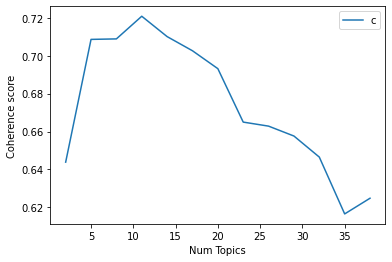

In [56]:
limit=40; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [57]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6438
Num Topics = 5  has Coherence Value of 0.7086
Num Topics = 8  has Coherence Value of 0.7089
Num Topics = 11  has Coherence Value of 0.7209
Num Topics = 14  has Coherence Value of 0.7101
Num Topics = 17  has Coherence Value of 0.7026
Num Topics = 20  has Coherence Value of 0.6932
Num Topics = 23  has Coherence Value of 0.665
Num Topics = 26  has Coherence Value of 0.6629
Num Topics = 29  has Coherence Value of 0.6576
Num Topics = 32  has Coherence Value of 0.6465
Num Topics = 35  has Coherence Value of 0.6165
Num Topics = 38  has Coherence Value of 0.6248


In [58]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.060*"support" + 0.054*"capacity" + 0.035*"implementation" + '
  '0.031*"technology" + 0.030*"international" + 0.027*"building" + '
  '0.027*"investment" + 0.022*"implement" + 0.022*"require" + '
  '0.021*"financial"'),
 (1,
  '0.035*"area" + 0.029*"population" + 0.028*"impact" + 0.025*"infrastructure" '
  '+ 0.023*"resource" + 0.023*"community" + 0.019*"health" + 0.016*"risk" + '
  '0.016*"vulnerable" + 0.016*"coastal"'),
 (2,
  '0.239*"climate" + 0.183*"change" + 0.115*"adaptation" + 0.035*"action" + '
  '0.025*"resilience" + 0.025*"impact" + 0.024*"priority" + 0.020*"address" + '
  '0.018*"vulnerability" + 0.017*"strengthen"'),
 (3,
  '0.067*"contribution" + 0.038*"indc" + 0.035*"action" + 0.029*"information" '
  '+ 0.026*"report" + 0.024*"objective" + 0.024*"mitigation" + 0.021*"set" + '
  '0.018*"update" + 0.016*"paris_agreement"'),
 (4,
  '0.157*"emission" + 0.058*"reduction" + 0.049*"target" + 0.025*"ghg" + '
  '0.025*"scenario" + 0.024*"estimate" + 0.023*"reduce" + 0.0

In [60]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = df.NDC_processed
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

NameError: ignored

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

In [ ]:
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

In [ ]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics